# Lightweight Transformer-based Model for Handwritten Character Recognition 
(https://hal.science/hal-03685976/file/A_Light_Transformer_Based_Architecture_for_Handwritten_Text_Recognition.pdf)

## ***note: Has a CNN backbone***

-----------

## Architecture  
Build up with a double Transformer architecture:  
- Image transformer as encoder: Extracts the visual features
- Text transformer as decoder: Language modeling
- Encoder: 
- Decoder: Generates word-sections sequence using visual features and previous predictions

### Encoder:  
- CNN Backbone (5 convolutions)
- Sinusodial position encoding  
- 4 layer transformer layer encoder

### Decoder: 
- Takes encoder output and along with sequence of previously predicted characters
- Additional loss in the middle of the network to help convergence

--------------


## Start pipeline

In [28]:
import os
from collections import OrderedDict, Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision.io import read_image
import torchvision as tv
import torch.nn.functional as F

from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Constants

In [29]:
DATA_PATH = f"/home/hkolstee/uniprojects/DATA/HWR/IAM-data/IAM-data/"
TRAIN_TEST_SPLIT = 0.2
BATCH_SIZE = 64
INPUT_HEIGHT = 128
# input width -> largest width in batch
# padded to get to width

### Prepare Data

In [30]:
raw_data = pd.read_fwf(DATA_PATH + "iam_lines_gt.txt", header = None)
raw_data = raw_data.values.tolist()

data = {'img_names': np.squeeze(raw_data[::2]),
        'labels': np.squeeze(raw_data[1::2])}

data = pd.DataFrame(data)
data

,img_names,labels
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country
...,...,...
7453,d06-000-08.png,fears are based upon completely
7454,d06-000-05.png,"is worrying them, to find the original"
7455,d06-000-09.png,irrational pre-conceived notions - or to
7456,d06-000-02.png,"already suggested, not to be silly or"


### TODO: Data augmentation

### Train test split

In [31]:
train, test = train_test_split(data, test_size = TRAIN_TEST_SPLIT)

# reset indices from current random state
train.reset_index(inplace = True)
test.reset_index(inplace = True)

### Create custom pytorch dataset

first, we need the input/image width we have to resize the images to.  
This is the largest image width in the entire batch of images (source paper randomly added/removed new augments each training epoch).   
For now we just take the largest width in the original images.

In [32]:
def getBiggestWidth(data: pd.DataFrame):
    biggest_width = 0

    for index in range(len(data['img_names'])):
        image_path = os.path.join(DATA_PATH, "img", data['img_names'][index])
        image = read_image(image_path)
        
        if (image.size(2) > biggest_width):
            biggest_width = image.size(2)

    return biggest_width

def getLongestLabel(data: pd.DataFrame):
    longest = 0
    
    for index in range(len(data['labels'])):
        if (len(data['labels'][index]) > longest):
            longest = len(data['labels'][index])
            
    return longest

Biggest width needed to pad all images to this width for the input into the encoder.  
Longest label needed to pad all labels to this length for the input into the decoder.


In [33]:
input_width = getBiggestWidth(data)
print(input_width)

longest_label = getLongestLabel(data)
# <BOS> and <EOS> tokens not counted
longest_label += 2
print(longest_label)

2260
56


For character level embedding (decoder input) we find out how many characters are present in the dataset.

In [34]:
# returns a dict of uniques chars sorted on how common they are in the dataset labels
def uniqueCharsByMostCommon(data: pd.DataFrame):
    sortedDict = OrderedDict(Counter(''.join(data['labels'].values)).most_common())
    newDict = {}
    
    # first add pad, begin of sentence, and end of sentence tokens
    newDict["<PAD>"] = 0
    newDict["<BOS>"] = 1
    newDict["<EOS>"] = 2
    
    for idx, char in enumerate(sortedDict):
        newDict[char] = idx + 3
    
    return newDict

In [35]:
class HandWritingDataset(Dataset):
    def __init__(self, data: pd.DataFrame, img_width, img_height, char_to_idx_mapping, max_label_size, batch_size):
        self.data = data
        self.batch_size = batch_size
        self.char_to_idx_mapping = char_to_idx_mapping
        self.idx_to_char_mapping = {value: key for key, value in self.char_to_idx_mapping.items()}

        # change character level strings to embed indices 
        #   (embedding itself calculated in forward pass)
        self.labels_as_idxs = [torch.tensor([[self.char_to_idx_mapping[char]] for char in label]) for label in data['labels']]   
        # add <BOS> and <EOS> tokens at begin and end of sentences
        self.labels_as_idxs = [torch.cat([torch.tensor([[self.char_to_idx_mapping['<BOS>']]]), label]) for label in self.labels_as_idxs]
        self.labels_as_idxs = [torch.cat([label, torch.tensor([[self.char_to_idx_mapping['<EOS>']]])]) for label in self.labels_as_idxs]
        
        # pad labels to largest label length with <pad> token
        # print(self.labels_as_idxs[0].shape)
        self.labels_as_idxs = [F.pad(label, (0, 0, 0, max_label_size - label.shape[0]), mode = 'constant', value = self.char_to_idx_mapping['<PAD>']) for label in self.labels_as_idxs]
        # print(self.labels_as_idxs[0].shape)
        
    def __getitem__(self, index):
        # input image
        image_path = os.path.join(DATA_PATH, "img", self.data['img_names'][index])
        # torchvision read_image call
        image = read_image(image_path)
        # resize to 
        
        # string label
        label = self.labels_as_idxs[index]

        return image, label

    def __len__(self):
        # return length of column
        return len(self.data)

In [36]:
# get mapping before splitting dataset
char_to_idx_mapping = uniqueCharsByMostCommon(data)

train_set = HandWritingDataset(train, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label, BATCH_SIZE)
test_set = HandWritingDataset(test, input_width, INPUT_HEIGHT, char_to_idx_mapping, longest_label, BATCH_SIZE)

char_to_idx_mapping

{'<PAD>': 0,
 '<BOS>': 1,
 '<EOS>': 2,
 ' ': 3,
 'e': 4,
 't': 5,
 'a': 6,
 'o': 7,
 'n': 8,
 'i': 9,
 's': 10,
 'r': 11,
 'h': 12,
 'l': 13,
 'd': 14,
 'c': 15,
 'u': 16,
 'm': 17,
 'f': 18,
 'p': 19,
 'w': 20,
 'g': 21,
 'y': 22,
 'b': 23,
 '.': 24,
 ',': 25,
 'v': 26,
 'k': 27,
 "'": 28,
 '"': 29,
 '-': 30,
 'T': 31,
 'I': 32,
 'M': 33,
 'A': 34,
 'S': 35,
 'B': 36,
 'P': 37,
 'H': 38,
 'W': 39,
 'C': 40,
 'N': 41,
 'G': 42,
 'x': 43,
 'R': 44,
 'L': 45,
 'E': 46,
 'D': 47,
 'F': 48,
 '0': 49,
 '1': 50,
 'j': 51,
 'O': 52,
 'q': 53,
 '!': 54,
 'U': 55,
 '(': 56,
 'K': 57,
 '?': 58,
 'z': 59,
 '3': 60,
 ')': 61,
 '9': 62,
 ';': 63,
 'V': 64,
 '2': 65,
 'J': 66,
 'Y': 67,
 ':': 68,
 '5': 69,
 '8': 70,
 '4': 71,
 '6': 72,
 '#': 73,
 '&': 74,
 '7': 75,
 '/': 76,
 'Q': 77,
 'X': 78,
 '*': 79,
 'Z': 80,
 '+': 81}

### Model 

Sinusodial positional encoding  
(can be changed to nn.embedding layers if we don't get good results, however that is not exactly sinusodial pos encoding like in the paper I think)

<!-- **CHANGED TO NN.EMBEDDING IN MODEL**   -->

In [37]:
class SinPosEncoding(nn.Module):
    def __init__(self, dimensionality):
        super(SinPosEncoding, self).__init__()
        self.dims = dimensionality
        self.max_len = 1000

        # position vector
        positions = torch.arange(0, self.max_len).unsqueeze(1)
        # calculate added angle for sin/cos
        angle = torch.exp(torch.arange(0, self.dims, 1) * (-np.log(10000.0) / self.dims))

        # initialize the 2D positional encodings array
        pos_encodings = torch.zeros(self.max_len, 1, self.dims)
        # calucalte encodings
        pos_encodings[:, 0, :] = torch.sin(positions * angle)

        # add to buffer for training performance (?)
        self.register_buffer('pos_encodings', pos_encodings)

    
    def forward(self, input: torch.Tensor):
        # print(input.shape)
        # print(self.pos_encodings.shape)
        # adds the positional encoding elementwise to the tensor (seqlength, batch, embeddims)
        input += self.pos_encodings[0:input.size(1)]
        # print("succes")

        return input

Model architecture

In [45]:
class HWRTransformer(nn.Module):
    def __init__(self, input_width, input_height, nr_char_tokens, output_dims):
        super(HWRTransformer, self).__init__()
        # convolutional block (5 convolutions)
        # first convolution
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3))
        width = input_width - 2
        height = input_height - 2
        self.leakyRelu = nn.LeakyReLU()     # reuse in later layers
        self.maxPool = nn.MaxPool2d((2,2))  # reuse in later layers
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm1 = nn.LayerNorm(normalized_shape = [8, height, width])
        self.dropout = nn.Dropout(0.2)      # reuse in later layers

        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm2 = nn.LayerNorm(normalized_shape = [16, height, width])


        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.layerNorm3 = nn.LayerNorm(normalized_shape = [32, height, width])

        # forth convolutional layer
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        width -= 2
        height -= 2
        # no maxpool
        self.layerNorm4 = nn.LayerNorm(normalized_shape = [64, height, width])

        # fifth convolutional layer (kernel size to better match shape of character)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 2))
        width -= 1
        height -= 3
        # no maxpool
        self.layerNorm5 = nn.LayerNorm(normalized_shape = [128, height, width])

        # following is convolution with width 1 which is used to flatten the current output
        self.flattenConv = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (height, 1))
        self.layerNorm6 = nn.LayerNorm(normalized_shape = [128, 1, width])

        # dense layer to upscale from 128 to 256
        self.dense1 = nn.Linear(in_features = 128, out_features = 256)
        # sinusoidal positional encoding is added to the output of the dense layer
        self.encoder_pos_encoding = SinPosEncoding(dimensionality = 256)

        # transformer encoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_encoder1 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder2 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder3 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_encoder4 = nn.TransformerEncoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)

        # Here starts: decoder
        # character embedding (dim rule of thumb -> 4th sqrt of nr_embeddings: for ~80 = 3) 
        #      NOTE: wrong, appearantly dims (encoder output, target embedding) need to be the same
        # <PAD> embedding idx = 0
        self.char_embedding = nn.Embedding(nr_char_tokens, 256, padding_idx = 0)
        # positional embedding of decoder input sequence
        self.decoder_pos_encoding = SinPosEncoding(dimensionality = 256)

        # transformer decoder layers (4 stacked transformer encoder layers (4 headed attention))
        self.trans_decoder1 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder2 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder3 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        self.trans_decoder4 = nn.TransformerDecoderLayer(d_model = 256, nhead = 4, dim_feedforward = 1024, dropout = 0.2)
        
        # dense layer size of output 
        self.decoder_out_dense = nn.Linear(256, nr_char_tokens)
        
    # character to index for lookup in char embedding table
    def charToIndex(self, char):
        return self.unique_chars.index(char)

    # first forward call: interm_outputs shoudl be a tensor with the embedding of <BOS>
    def forward(self, input_img, target_seq):
        # through 5 convolutional layers
        # first conv
        encoder_out = self.layerNorm1(self.maxPool(self.leakyRelu(self.conv1(input_img))))
        encoder_out = self.dropout(encoder_out)
        # second conv
        encoder_out = self.layerNorm2(self.maxPool(self.leakyRelu(self.conv2(encoder_out))))
        encoder_out = self.dropout(encoder_out)
        # third conv
        encoder_out = self.layerNorm3(self.maxPool(self.leakyRelu(self.conv3(encoder_out))))
        encoder_out = self.dropout(encoder_out)
        # forth conv
        encoder_out = self.layerNorm4(self.leakyRelu(self.conv4(encoder_out)))
        # fifth conv
        encoder_out = self.layerNorm5(self.leakyRelu(self.conv5(encoder_out)))

        # flatten layer
        encoder_out = self.layerNorm6(self.leakyRelu(self.flattenConv(encoder_out)))

        # dense layer (activation function not mentioned in paper) 
        # needs reshaped tensor where dims are reversed ((batch, 128, 1, x) -> (batch, x, 1, 128))
        encoder_out = torch.reshape(encoder_out, (encoder_out.size(0), encoder_out.size(3), encoder_out.size(2), encoder_out.size(1)))
        encoder_out = self.dense1(encoder_out)

        # add sinusodial positional information
        # needs reshape (batch, seq_len, 1, 256) -> (seq_len, batch, 256)  
        encoder_out = torch.reshape(encoder_out, (encoder_out.size(1), encoder_out.size(0), encoder_out.size(3)))
        encoder_out = self.encoder_pos_encoding(encoder_out)

        # transformer encoder layers
        encoder_out = self.trans_encoder1(encoder_out)
        encoder_out = self.trans_encoder2(encoder_out)
        encoder_out = self.trans_encoder3(encoder_out)
        encoder_out = self.trans_encoder4(encoder_out)

        # encoder output for CTC Loss
        interm_encoder_out = encoder_out

        # add sinusodial positional information again
        encoder_out = self.encoder_pos_encoding(encoder_out)

        # target sequence (shifted right (so with <BOS> token))
        decoder_in = self.char_embedding(target_seq)
        
        # add sinusoidal positional information to decoder input
        decoder_in = self.decoder_pos_encoding(decoder_in)
        
        print("decoder in:", decoder_in.shape)
        
        # input encoder output and predicted chars into decoder (TODO: teacher forcing)
        decoder_out = self.trans_decoder1(decoder_in, encoder_out)
        decoder_out = self.trans_decoder2(decoder_out, encoder_out)
        decoder_out = self.trans_decoder3(decoder_out, encoder_out)
        decoder_out = self.trans_decoder4(decoder_out, encoder_out)

        # dense layer after decoder to predict one of all tokens
        print("decoder out:", decoder_out.shape)
        decoder_out = self.decoder_out_dense(decoder_out)
        print("dense out:", decoder_out.shape)

        return interm_encoder_out, decoder_out

### Resize and pad images

In [46]:
# resizes to largest width in batch x 128, keeping aspect ratio and padding image
def resizeBatch(images, image_width, image_height):
    resized_batch = torch.empty((images.size(0), 1, image_height, image_width), dtype = torch.float32)
    resize_transform = tv.transforms.Resize((image_height, image_width), antialias = True)


    for idx, image in enumerate(images):
        resized = resize_transform(image)
        resized_batch[idx] = resized

    return resized_batch

test with one image

decoder in: torch.Size([56, 1, 256])
decoder out: torch.Size([56, 1, 256])
dense in: torch.Size([56, 1, 56])
torch.Size([277, 1, 256]) torch.Size([56, 1, 56])


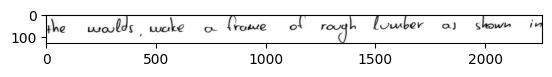

In [47]:
hwr_transformer = HWRTransformer(input_width, INPUT_HEIGHT, longest_label, char_to_idx_mapping)

test_image, test_label = train_set.__getitem__(2)
# print("Mean of image: %.2f" % test_image.float().mean().item())
# print(test_label)

# create "batches" with single image / label 
test_image_batch = test_image.unsqueeze(0)

# resize
resized_batch = resizeBatch(test_image_batch, input_width, INPUT_HEIGHT)
# print(resized_batch.size())

plt.imshow(resized_batch[0, 0, :, :], cmap = "gray")

# test label = <BOS> *sentence in tokens* <EOS> <PAD> <PAD> ... 
out1, out2 = hwr_transformer(resized_batch, test_label)
print(out1.shape, out2.shape)